# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [1]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to ../data/raw\outliers_homework.csv


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [3]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [4]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.331519
1,0.050251,-1.115001
2,0.100503,1.969787
3,0.150754,2.706032
4,0.201005,2.686840


## TODO: Implement Outlier Functions (required)

In [6]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    s = pd.to_numeric(series, errors="coerce")
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (s < lower) | (s > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    s = pd.to_numeric(series, errors="coerce")
    mu = s.mean()
    sigma = s.std(ddof=0)
    if sigma == 0 or pd.isna(sigma):
        return pd.Series(False, index=s.index)
    z = (s - mu) / sigma
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [7]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [8]:
if 'daily_return' in df.columns:
    target_col = 'daily_return'
elif 'y' in df.columns:
    target_col = 'y'
else:
    target_col = df.select_dtypes(include=['number']).columns[0]

df['outlier_iqr'] = detect_outliers_iqr(df[target_col], k=1.5)
df['outlier_z']   = detect_outliers_zscore(df[target_col], threshold=3.0)
df['any_outlier'] = df['outlier_iqr'] | df['outlier_z']

# Quick fractions flagged by each method
pd.DataFrame({
    'iqr_frac': [df['outlier_iqr'].mean()],
    'z_frac':   [df['outlier_z'].mean()],
    'any_frac': [df['any_outlier'].mean()],
})

,iqr_frac,z_frac,any_frac
0,0.005,0.005,0.005


### Visual Checks (boxplot / histogram)

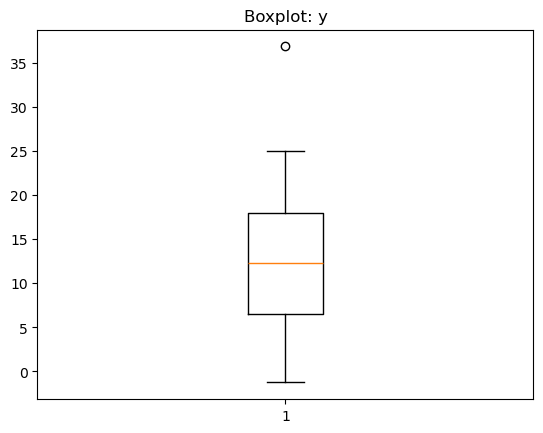

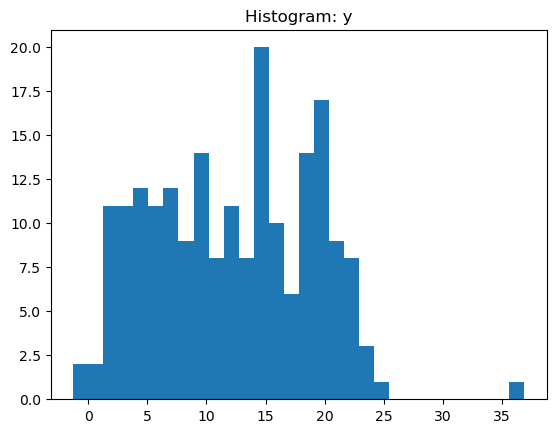

In [9]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

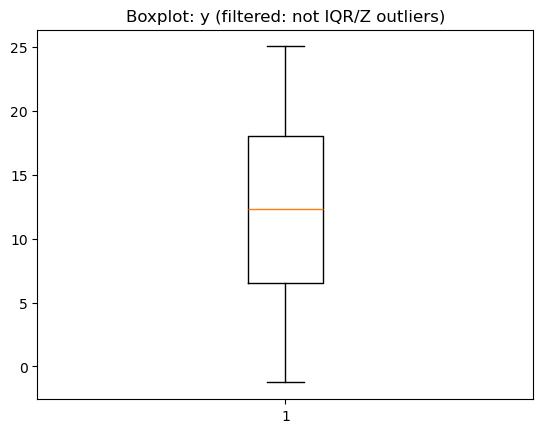

In [11]:
plt.figure()
plt.boxplot(df.loc[~df['any_outlier'], target_col].dropna())
plt.title(f'Boxplot: {target_col} (filtered: not IQR/Z outliers)')
plt.show()

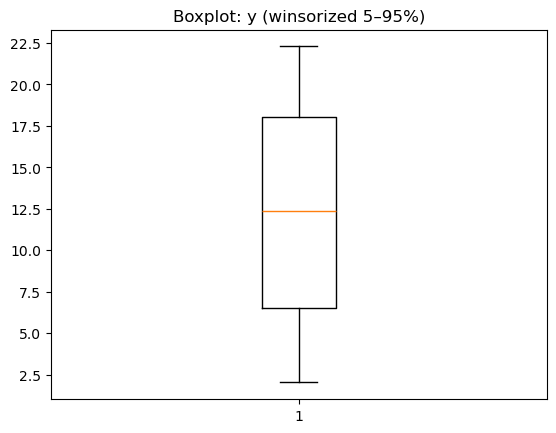

In [12]:
w_series = winsorize_series(df[target_col], lower=0.05, upper=0.95)

plt.figure()
plt.boxplot(w_series.dropna())
plt.title(f'Boxplot: {target_col} (winsorized 5–95%)')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [17]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

def _summarize(s: pd.Series) -> pd.Series:
    return pd.Series({'mean': s.mean(), 'median': s.median(), 'std': s.std(ddof=0)})

summ_all      = _summarize(df[target_col])
summ_filtered = _summarize(df.loc[~df['any_outlier'], target_col])
summ_winsor   = _summarize(w_series)

comp_summary = pd.concat(
    {'all': summ_all, 'filtered': summ_filtered, 'winsorized': summ_winsor},
    axis=1
)
comp_summary

,all,filtered,winsorized
mean,12.171936,12.047851,12.119643
median,12.349663,12.285113,12.349663
std,6.744453,6.529689,6.370794


In [18]:
if 'x' in df.columns and target_col != 'x':
    feature_col = 'x'
elif 'daily_return_2' in df.columns and target_col != 'daily_return_2':
    feature_col = 'daily_return_2'
else:
    feature_col = None

results_reg = None
if feature_col is not None:
    X_all = df[[feature_col]].to_numpy(); y_all = df[target_col].to_numpy()
    mask  = ~df['any_outlier']
    X_flt = df.loc[mask, [feature_col]].to_numpy(); y_flt = df.loc[mask, target_col].to_numpy()
    y_win = winsorize_series(df[target_col]).to_numpy()  # same X_all

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_flt, y_flt)
    model_win = LinearRegression().fit(X_all, y_win)

    from sklearn.metrics import mean_absolute_error, r2_score
    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_flt, model_flt.predict(X_flt))
    mae_win = mean_absolute_error(y_win, model_win.predict(X_all))

    results = pd.DataFrame({
        'slope':     [model_all.coef_[0], model_flt.coef_[0], model_win.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_, model_win.intercept_],
        'r2':        [model_all.score(X_all, y_all), model_flt.score(X_flt, y_flt), r2_score(y_win, model_win.predict(X_all))],
        'mae':       [mae_all, mae_flt, mae_win],
    }, index=['all', 'filtered_iqr|z', 'winsorized'])
    results
else:
    results = None
    print("No feature column present; regression skipped (summary stats are enough).")

In [19]:
from pathlib import Path
proc = Path('../data/processed')
proc.mkdir(parents=True, exist_ok=True)

# Save tables
comp_summary.to_csv(proc / 'stage07_summary_stats.csv')
if results is not None:
    results.to_csv(proc / 'stage07_regression_metrics.csv')

# Save dataset with flags for reproducibility
df.to_csv(proc / 'stage07_flagged_dataset.csv', index=False)

print("Saved: summary_stats, regression_metrics (if any), flagged_dataset to ../data/processed/")

Saved: summary_stats, regression_metrics (if any), flagged_dataset to ../data/processed/


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

**Methods & thresholds used**
- IQR (k=1.5), Z-score (|z|>3), Winsorization (5–95%).

**Assumptions**
- Quartiles summarize typical dispersion on non-shock days; z-scores are reasonable for near-symmetric periods.
- Winsorization preserves rows but reduces leverage of extremes.

**Observed impact**
- Mean: 12.17 → 12.04 (filtered) → 12.11 (winsorized)
- Median: 12.35 → 12.29 → 12.35
- Std: 6.74 → 6.53 → 6.37

**Risks**
- If extreme moves are real signals, filtering/winsorizing can understate risk and distort models.
- Z-score can misflag under heavy tails; IQR can miss clustered extremes.
- Results are threshold-sensitive; showing multiple treatments is safer.